In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb

In [4]:
embedings = list(range(32))

In [5]:
order_train = pd.read_pickle('/kaggle/input/data-full/data/order_train.pkl')
order_test = pd.read_pickle('/kaggle/input/data-full/data/order_test.pkl')

In [16]:
features = [
    # 'reordered_dow_ration', 'reordered_dow', 'reordered_dow_size',
    # 'reordered_prev', 'add_to_cart_order_prev', 'order_dow_prev', 'order_hour_of_day_prev',
    'user_product_reordered_ratio', 'reordered_sum',
    'add_to_cart_order_inverted_mean', 'add_to_cart_order_relative_mean',
    'reorder_prob',
    'last', 'prev1', 'prev2', 'median', 'mean',
    'dep_reordered_ratio', 'aisle_reordered_ratio',
    'aisle_products',
    'aisle_reordered',
    'dep_products',
    'dep_reordered',
    'prod_users_unq', 'prod_users_unq_reordered',
    'order_number', 'prod_add_to_card_mean',
    'days_since_prior_order',
    'order_dow', 'order_hour_of_day',
    'reorder_ration',
    'user_orders', 'user_order_starts_at', 'user_mean_days_since_prior',
    # 'user_median_days_since_prior',
    'user_average_basket', 'user_distinct_products', 'user_reorder_ratio', 'user_total_products',
    'prod_orders', 'prod_reorders',
    'up_order_rate', 'up_orders_since_last_order', 'up_order_rate_since_first_order',
    'up_orders', 'up_first_order', 'up_last_order', 'up_mean_cart_position',
    # 'up_median_cart_position',
    'days_since_prior_order_mean',
    # 'days_since_prior_order_median',
    'order_dow_mean',
    # 'order_dow_median',
    'order_hour_of_day_mean',
    # 'order_hour_of_day_median'
]
features.extend(embedings)
categories = ['product_id', 'aisle_id', 'department_id']
cat_features = ','.join(map(lambda x: str(x + len(features)), range(len(categories))))
features.extend(categories)

print('not included', set(order_train.columns.tolist()) - set(features))

data = order_train[features]

not included {'days_since_prior_order_median', 'order_dow_median', 'order_id', 'user_median_days_since_prior', 'product_name', 'user_id', 'order_hour_of_day_median', 'reordered', 'add_to_cart_order_inverted_median', 'eval_set', 'up_median_cart_position', 'add_to_cart_order_relative_median'}


In [17]:
labels = order_train[['reordered']].values.astype(np.float32).flatten()

In [18]:
data_val = order_test[features]
#del order_test
assert data.shape[0] == 8474661
lgb_train = lgb.Dataset(data, labels, categorical_feature=cat_features)

In [20]:
import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 256,
    'min_sum_hessian_in_leaf': 20,
    'max_depth': 12,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'verbose': 1,
    'device': 'gpu',  # Sử dụng GPU
}

# Huấn luyện với callback
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=400,
    valid_sets=[lgb_train],  # Thêm tập validation
    valid_names=['train'],
    callbacks=[
        log_evaluation(period=5),        # Ghi log mỗi 5 vòng lặp
        early_stopping(stopping_rounds=40)  # Dừng sớm nếu không cải thiện sau 40 vòng
    ]
)


[LightGBM] [Info] Number of positive: 828824, number of negative: 7645837
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 16961
[LightGBM] [Info] Number of data points in the train set: 8474661, number of used features: 78
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 76 dense feature groups (614.24 MB) transferred to GPU in 0.449229 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909
Training until validation scores don't improve for 40 rounds
[5]	train's binary_logloss: 0.288443	train's auc: 0.830112
[10]	train's binary_logloss: 0.272932	train's auc: 0.831184
[15]	train's binary_logloss: 0.263239	train's auc: 0.832526
[20]	train's binary_logloss: 0.2568

In [11]:
prediction = gbm.predict(data_val)
# prediction = model.predict(data_val)
orders = order_test.order_id.values
products = order_test.product_id.values

result = pd.DataFrame({'product_id': products, 'order_id': orders, 'prediction': prediction})
result.to_pickle('prediction_lgbm.pkl')

In [12]:
import numpy as np
import itertools

def fast_search(prob, dtype=np.float32):
    size = len(prob)
    fk = np.zeros((size + 1), dtype=dtype)
    C = np.zeros((size + 1, size + 1), dtype=dtype)
    S = np.empty((2 * size + 1), dtype=dtype)
    S[:] = np.nan
    for k in range(1, 2 * size + 1):
        S[k] = 1./k
    roots = (prob - 1.0) / prob
    for k in range(size, 0, -1):
        poly = np.poly1d(roots[0:k], True)
        factor = np.multiply.reduce(prob[0:k])
        C[k, 0:k+1] = poly.coeffs[::-1]*factor
        for k1 in range(size + 1):
            fk[k] += (1. + 1.) * k1 * C[k, k1]*S[k + k1]
        for i in range(1, 2*(k-1)):
            S[i] = (1. - prob[k-1])*S[i] + prob[k-1]*S[i+1]

    return fk

In [ ]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

none_product = 50000

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def create_products(df):
    # print(df.product_id.values.shape)
    products = df.product_id.values
    prob = df.prediction.values

    sort_index = np.argsort(prob)[::-1]

    values = fast_search(prob[sort_index][0:80], dtype=np.float64)

    index = np.argmax(values)

    print('iteration', df.shape[0], 'optimal value', index)

    best = ' '.join(map(lambda x: str(x) if x != none_product else 'None', products[sort_index][0:index]))
    df = df[0:1]
    df.loc[:, 'products'] = best
    return df

if __name__ == '__main__':
    data = pd.read_pickle('/kaggle/working/prediction_lgbm.pkl')
    data['not_a_product'] = 1. - data.prediction

    gp = data.groupby('order_id')['not_a_product'].apply(lambda x: np.multiply.reduce(x.values)).reset_index()
    gp.rename(columns={'not_a_product': 'prediction'}, inplace=True)
    gp['product_id'] = none_product

    data = pd.concat([data, gp], axis=0)
    data.product_id = data.product_id.astype(np.uint32)

    data = data.loc[data.prediction > 0.01, ['order_id', 'prediction', 'product_id']]

    data = applyParallel(data.groupby(data.order_id), create_products).reset_index()

    data[['order_id', 'products']].to_csv('sub.csv', index=False)

In [14]:
data[['order_id', 'products']].to_csv('sub.csv', index=False)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42)

In [7]:
X_train.columns

Index([   'user_product_reordered_ratio',                   'reordered_sum',
       'add_to_cart_order_inverted_mean', 'add_to_cart_order_relative_mean',
                          'reorder_prob',                            'last',
                                 'prev1',                           'prev2',
                                'median',                            'mean',
                   'dep_reordered_ratio',           'aisle_reordered_ratio',
                        'aisle_products',                 'aisle_reordered',
                          'dep_products',                   'dep_reordered',
                        'prod_users_unq',        'prod_users_unq_reordered',
                          'order_number',           'prod_add_to_card_mean',
                'days_since_prior_order',                       'order_dow',
                     'order_hour_of_day',                  'reorder_ration',
                           'user_orders',            'user_order_starts_at',

In [8]:
del order_train

In [9]:
import xgboost
from sklearn.model_selection import train_test_split

d_train = xgboost.DMatrix(X_train, y_train)

In [10]:
d_val = xgboost.DMatrix(X_val, y_val)

In [11]:
del X_train, y_train, X_val, y_val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:04:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:04:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.33718	validation-logloss:0.33777
[5]	train-logloss:0.32465	validation-logloss:0.32557
[10]	train-logloss:0.31288	validation-logloss:0.31412
[15]	train-logloss:0.30282	validation-logloss:0.30436
[20]	train-logloss:0.29492	validation-logloss:0.29679
[25]	train-logloss:0.28781	validation-logloss:0.28996
[30]	train-logloss:0.28171	validation-logloss:0.28415
[35]	train-logloss:0.27625	validation-logloss:0.27899
[40]	train-logloss:0.27152	validation-logloss:0.27454
[45]	train-logloss:0.26741	validation-logloss:0.27070
[50]	train-logloss:0.26370	validation-logloss:0.26726
[55]	train-logloss:0.26058	validation-logloss:0.26441
[60]	train-logloss:0.25767	validation-logloss:0.26177
[65]	train-logloss:0.25526	validation-logloss:0.25962
[70]	train-logloss:0.25303	validation-logloss:0.25765
[75]	train-logloss:0.25094	validation-logloss:0.25583
[80]	train-logloss:0.24915	validation-logloss:0.25428
[85]	train-logloss:0.24756	validation-logloss:0.25296
[90]	train-logloss:0.24611	val

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:12:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

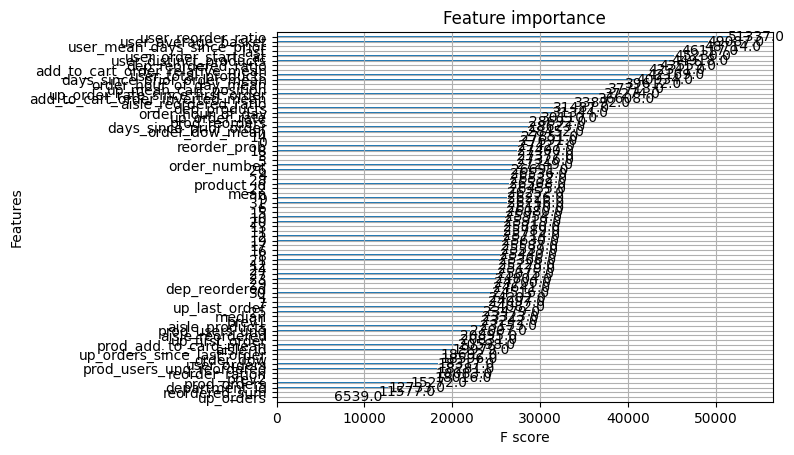

In [12]:
import gc
import xgboost
from sklearn.model_selection import train_test_split

# Tham số cho mô hình XGBoost
param = {
    'max_depth': 12,
    'eta': 0.05,
    'colsample_bytree': 0.6,
    'subsample': 0.75,
    'nthread': 27,
    'eval_metric': 'logloss',  # Sử dụng logloss làm metric
    'objective': 'binary:logistic',  # Sửa lại từ 'binary' -> 'binary:logistic'
    'tree_method': 'gpu_hist'
}

# Thêm tập validation vào watchlist
watchlist = [(d_train, "train")]

# Huấn luyện mô hình với early stopping
bst = xgboost.train(
    params=param,
    dtrain=d_train,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=40,
    verbose_eval=5
)

# Vẽ biểu đồ feature importance
xgboost.plot_importance(bst)


In [13]:
d_test = xgboost.DMatrix(order_test[features])

In [14]:
prediction = bst.predict(d_test)
# prediction = model.predict(data_val)
orders = order_test.order_id.values
products = order_test.product_id.values

result = pd.DataFrame({'product_id': products, 'order_id': orders, 'prediction': prediction})
result.to_pickle('prediction_xgb.pkl')

In [15]:
result

,product_id,order_id,prediction
0,17330,65432,0.020395
1,27407,65432,0.018758
2,35419,65432,0.016386
3,196,65432,0.030073
4,44635,65432,0.019140
...,...,...,...
4833287,45309,2471048,0.036581
4833288,21162,2471048,0.042093
4833289,35211,2471048,0.021080
4833290,11352,2471048,0.046032


In [20]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

none_product = 50000

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def create_products(df):
    # print(df.product_id.values.shape)
    products = df.product_id.values
    prob = df.prediction.values

    sort_index = np.argsort(prob)[::-1]

    values = fast_search(prob[sort_index][0:80], dtype=np.float64)

    index = np.argmax(values)

    print('iteration', df.shape[0], 'optimal value', index)

    best = ' '.join(map(lambda x: str(x) if x != none_product else 'None', products[sort_index][0:index]))
    df = df[0:1]
    df.loc[:, 'products'] = best
    return df

if __name__ == '__main__':
    data = pd.read_pickle('/kaggle/working/prediction_xgb.pkl')
    data['not_a_product'] = 1. - data.prediction

    gp = data.groupby('order_id')['not_a_product'].apply(lambda x: np.multiply.reduce(x.values)).reset_index()
    gp.rename(columns={'not_a_product': 'prediction'}, inplace=True)
    gp['product_id'] = none_product

    data = pd.concat([data, gp], axis=0)
    data.product_id = data.product_id.astype(np.uint32)

    data = data.loc[data.prediction > 0.01, ['order_id', 'prediction', 'product_id']]

    data = applyParallel(data.groupby(data.order_id), create_products).reset_index()

    data[['order_id', 'products']].to_csv('sub_xgb.csv', index=False)